# ResNet-18: Train only output layer - PyTorch

Using CIFAR-10 dataset. Freeze all other non output layers, and only train the output (softmax) layer.

In [1]:
# Specify GPU to be used-
%env CUDA_DEVICE_ORDER = PCI_BUS_ID
'''
Specify GPU(s) to be used here. Say you have 6 GPUs and you want to train Model A on 2 of them
and Model B on 4 of them. You can do that as follows-
CUDA_VISIBLE_DEVICES=0,1 python model_A.py
CUDA_VISIBLE_DEVICES=2,3,4,5 python model_B.py
'''
# %env CUDA_VISIBLE_DEVICES = 0, 1, 2, 3
%env CUDA_VISIBLE_DEVICES = 0

env: CUDA_DEVICE_ORDER=PCI_BUS_ID
env: CUDA_VISIBLE_DEVICES=0


In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
# import torchvision.transforms as transforms

from tqdm import tqdm
from tqdm import trange
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os, pickle
import albumentations as A
from albumentations.pytorch import ToTensorV2

Matplotlib is building the font cache; this may take a moment.
/home/majumdar/anaconda3/envs/torch-cuda-new/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
print(f"torch version: {torch.__version__}")

# Check if there are multiple devices (i.e., GPU cards)-
print(f"Number of GPU(s) available = {torch.cuda.device_count()}")

# Which GPU Is The Current GPU?
# print(f"current GPU: {torch.cuda.current_device()}")

# Get the name of the current GPU-
# print(f"Current GPU name: {torch.cuda.get_device_name(torch.cuda.current_device())}")

# Is PyTorch using a GPU?
# print(f"Is PyTorch using a GPU? {torch.cuda.is_available()}")

if torch.cuda.is_available():
    print(f"Current GPU: {torch.cuda.current_device()}")
    print(f"Current GPU name: {torch.cuda.get_device_name(torch.cuda.current_device())}")
else:
    print("PyTorch does not have access to GPU")

torch version: 1.13.1
Number of GPU(s) available = 1
Current GPU: 0
Current GPU name: NVIDIA GeForce GTX TITAN X


In [ ]:
# print(torch.cuda.memory_summary())

In [4]:
# Device configuration-
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Available device is {device}')

Available device is cuda


In [5]:
# Specify hyper-parameters
batch_size = 256
num_classes = 10
num_epochs = 80

In [6]:
# Define transformations using albumentations-
transform_train = A.Compose(
    [
        # A.Resize(width = 32, height = 32),
        # A.RandomCrop(width = 20, height = 20),
        A.Rotate(limit = 40, p = 0.9, border_mode = cv2.BORDER_CONSTANT),
        A.HorizontalFlip(p = 0.5),
        A.VerticalFlip(p = 0.1),
        A.RGBShift(r_shift_limit = 25, g_shift_limit = 25, b_shift_limit = 25, p = 0.9),
        A.OneOf([
            A.Blur(blur_limit = 3, p = 0.5),
            A.ColorJitter(p = 0.5),
        ], p = 1.0),
        A.Normalize(
            # mean = [0.4914, 0.4822, 0.4465],
            # std = [0.247, 0.243, 0.261],
            mean = [0, 0, 0],
            std = [1, 1, 1],
            max_pixel_value = 255,
        ),
        # This is not dividing by 255, which it does in PyTorch-
        ToTensorV2(),
    ]
)

transform_val = A.Compose(
    [
        A.Normalize(
            mean = [0, 0, 0],
            std = [1, 1, 1],
            max_pixel_value = 255
        ),
        ToTensorV2()
    ]
)

In [7]:
class Cifar10Dataset(torchvision.datasets.CIFAR10):
    def __init__(
        self, root = "~/data/cifar10",
        train = True, download = True,
        transform = None
    ):
        super().__init__(
            root = root, train = train,
            download = download, transform = transform
        )

    def __getitem__(self, index):
        image, label = self.data[index], self.targets[index]

        if self.transform is not None:
            transformed = self.transform(image = image)
            image = transformed["image"]

        return image, label
    

In [8]:
# Define train and validate sets-
train_dataset = Cifar10Dataset(
    root = '/home/majumdar/Downloads/.data/', train = True,
    download = True, transform = transform_train
)

val_dataset = Cifar10Dataset(
    root = '/home/majumdar/Downloads/.data/', train = False,
    download = True, transform = transform_val
)

Files already downloaded and verified
Files already downloaded and verified


In [9]:
# Define train and validate loaders-
train_loader = torch.utils.data.DataLoader(
    dataset = train_dataset, batch_size = batch_size,
    shuffle = True
    )

val_loader = torch.utils.data.DataLoader(
    dataset = val_dataset, batch_size = batch_size,
    shuffle = True
    )

In [10]:
print(f"len(train_dataset) = {len(train_dataset)} & len(val_dataset) = {len(val_dataset)}")
print(f"len(train_loader) = {len(train_loader)} & len(val_loader) = {len(val_loader)}")

len(train_dataset) = 50000 & len(val_dataset) = 10000
len(train_loader) = 196 & len(val_loader) = 40


In [11]:
# Sanity check-
len(train_dataset) / batch_size, len(val_dataset) / batch_size

(195.3125, 39.0625)

In [12]:
class ResNet_Block(nn.Module):
    '''
    VGG block within a VGG-* CNN model
    '''
    def __init__(
        self, num_inp_channels,
        num_channels, stride = 1,
        dropout = 0.2, use_1x1_conv = False
    ):
        super(ResNet_Block, self).__init__()
        
        self.num_inp_channels = num_inp_channels
        self.num_channels = num_channels
        self.stride = stride
        self.dropout = dropout
        self.use_1x1_conv = use_1x1_conv
    
        
        self.conv1 = nn.Conv2d(
            in_channels = self.num_inp_channels, out_channels = self.num_channels,
            kernel_size = 3, padding = 1,
            stride = self.stride, bias = False
        )
        self.bn1 = nn.BatchNorm2d(num_features = self.num_channels)
        
        self.conv2 = nn.Conv2d(
            in_channels = self.num_channels, out_channels = self.num_channels,
            kernel_size = 3, padding = 1,
            stride = 1, bias = False
        )
        self.bn2 = nn.BatchNorm2d(num_features = self.num_channels)
        self.dropout = nn.Dropout(p = self.dropout)
        
        if self.use_1x1_conv:
            self.conv3 = nn.Conv2d(
            in_channels = self.num_inp_channels, out_channels = num_channels,
            kernel_size = 1, padding = 0,
            stride = self.stride, bias = False
            )
            self.bn3 = nn.BatchNorm2d(num_features = self.num_channels)
        
        self.initialize_weights()

            
    def initialize_weights(self):
        for m in self.modules():
            # print(m)
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight)

                '''
                # Do not initialize bias (due to batchnorm)-
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
                '''
            
            elif isinstance(m, nn.BatchNorm2d):
                # Standard initialization for batch normalization-
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

            elif isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight)
                nn.init.constant_(m.bias, 0)
    
    
    def forward(self, x):
        y = F.leaky_relu(self.bn1(self.conv1(x)))
        y = self.dropout(F.leaky_relu(self.bn2(self.conv2(y))))
        
        if self.use_1x1_conv:
            x = self.bn3(self.conv3(x))
            
        y += x
        return F.leaky_relu(self.dropout(y))
    
    
    def shape_computation(self, x):
        print(f"Input shape: {x.shape}")
        y = (self.bn1(self.conv1(x)))
        print(f"First conv layer output shape: {y.shape}")
        y = self.bn2(self.conv2(y))
        print(f"Second conv layer output shape: {y.shape}")
        
        if self.use_1x1_conv:
            x = self.bn3(self.conv3(x))
            print(f"Downsample with S = 2; identity connection output shape: {x.shape}")
            
        y += x
        print(f"Residual block output shape: {y.shape}")
        return None
    

In [13]:
class ResNet18(nn.Module):
    def __init__(self):
        super(ResNet18, self).__init__()
        
        self.conv1 = nn.Conv2d(
            in_channels = 3, out_channels = 64,
            kernel_size = 3, padding = 1,
            stride = 1, bias = False
        )
        self.bn1 = nn.BatchNorm2d(num_features = 64)
        
        self.resblock1 = ResNet_Block(
            num_inp_channels = 64, num_channels = 64,
            stride = 1, dropout = 0.2,
            use_1x1_conv = False
        )
        
        self.resblock2 = ResNet_Block(
            num_inp_channels = 64, num_channels = 64,
            stride = 1, dropout = 0.2,
            use_1x1_conv = False
        )
        
        # Downsample-
        self.resblock3 = ResNet_Block(
            num_inp_channels = 64, num_channels = 128,
            stride = 2, dropout = 0.2,
            use_1x1_conv = True
        )
        
        self.resblock4 = ResNet_Block(
            num_inp_channels = 128, num_channels = 128,
            stride = 1, dropout = 0.2,
            use_1x1_conv = False
        )

        # Downsample-
        self.resblock5 = ResNet_Block(
            num_inp_channels = 128, num_channels = 256,
            stride = 2, dropout = 0.2,
            use_1x1_conv = True
        )

        self.resblock6 = ResNet_Block(
            num_inp_channels = 256, num_channels = 256,
            stride = 1, dropout = 0.2,
            use_1x1_conv = False
        )

        # Downsample-
        self.resblock7 = ResNet_Block(
            num_inp_channels = 256, num_channels = 512,
            stride = 2, dropout = 0.2,
            use_1x1_conv = True
        )

        self.resblock8 = ResNet_Block(
            num_inp_channels = 512, num_channels = 512,
            stride = 1, dropout = 0.2,
            use_1x1_conv = False
        )
        
        self.avg_pool = nn.AvgPool2d(kernel_size = 3, stride = 2)
        self.op_layer = nn.Linear(
            in_features = 512, out_features = 10,
            bias = True
        )
        
    
    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.resblock1(x)
        x = self.resblock2(x)
        x = self.resblock3(x)
        x = self.resblock4(x)
        x = self.resblock5(x)
        x = self.resblock6(x)
        x = self.resblock7(x)
        x = self.resblock8(x)
        x = self.avg_pool(x).squeeze()
        x = self.op_layer(x)
        return x
    

In [14]:
# Initialize ResNet-18 architecture-
model = ResNet18().to(device)

In [15]:
# Count number of layer-wise parameters and total parameters-
tot_params = 0
for param in model.parameters():
    # print(f"layer.shape = {param.shape} has {param.nelement()} parameters")
    tot_params += param.nelement()
    
print(f"ResNet-18 CNN has {tot_params} total trainable parameters")

ResNet-18 CNN has 11173962 total trainable parameters


In [16]:
# Save random initial weights-
torch.save(model.state_dict(), 'ResNet18_random_weights.pth')

# Load randomly initialised weights-
# model.load_state_dict(torch.load('VGG18_random_weights_dropouts.pth'))

In [20]:
# Freeze all features-
for layer_name, param in model.named_parameters():
    param.requires_grad = False
    # print(f"layre: {layer_name}, shape: {param.shape}")

In [21]:
# Only train new output dense layer-
model.op_layer.weight.requires_grad = True
model.op_layer.bias.requires_grad = True

In [22]:
# Define loss function and optimizer-
loss = nn.CrossEntropyLoss()

# optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)
optimizer = torch.optim.SGD(model.parameters(), lr = 0.0, momentum = 0.9, weight_decay = 5e-4)

#### Train model with learning rate scheduler

Training dataset = 50000, batch size = 256, number of training steps/iterations per epoch = 50000 / 256 = 195.3125 = 195

After an initial linear learning rate warmup of 13 epochs or 2539 training steps:

- For the next 32 epochs, or, 6250 steps - until 43rd epoch, use lr = 0.1.

- For the next 25 epochs, or, 4882 steps - until 68th epoch, use lr = 0.01.

- For remaining epochs (13 epochs), use lr = 0.001.

In [23]:
boundaries = [6250, 11132]
values = [0.1, 0.01, 0.001]

In [24]:
def decay_function(step, boundaries = [6250, 11132], values = [0.1, 0.01, 0.001]):
    
    for idx, bound in enumerate(boundaries):
        if step < bound:
            return values[idx]

    return values[-1]
    

In [25]:
class schedule():

    def __init__(self, initial_learning_rate = 0.1, warmup_steps = 1000, decay_func = None):
        self.initial_learning_rate = initial_learning_rate
        self.warmup_steps = warmup_steps
        self.decay_func = decay_func
        self.warmup_step_size = initial_learning_rate/warmup_steps
        self.current_lr = 0

    def get_lr(self, step):
        if step == 0:
            return self.current_lr
        elif step <= self.warmup_steps:
            self.current_lr+=self.warmup_step_size
            return self.current_lr
        elif step > self.warmup_steps:
            if self.decay_func:
                return self.decay_func(step)
        else:
            return self.current_lr
        

In [26]:
# Initial linear LR warmup: 195.3125 x 13 = 2549 steps in 13 epochs.
custom_lr_scheduler = schedule(
    initial_learning_rate = 0.1, warmup_steps = 2539,
    decay_func = decay_function
)


In [27]:
step = 0

In [28]:
def train_model_progress(model, train_loader, train_dataset):
    '''
    Function to perform one epoch of training by using 'train_loader'.
    Returns loss and number of correct predictions for this epoch.
    '''
    running_loss = 0.0
    running_corrects = 0.0
    
    model.train()
    
    with tqdm(train_loader, unit = 'batch') as tepoch:
        for images, labels in tepoch:
            tepoch.set_description(f"Training: ")
            
            images = images.to(device)
            labels = labels.to(device)
            
            # Get model predictions-
            outputs = model(images)
            
            # Compute loss-
            J = loss(outputs, labels)
            
            # Empty accumulated gradients-
            optimizer.zero_grad()
            
            # Perform backprop-
            J.backward()
            
            # Update parameters-
            optimizer.step()
            
            global step
            optimizer.param_groups[0]['lr'] = custom_lr_scheduler.get_lr(step)

            step += 1
            
            # Compute model's performance statistics-
            running_loss += J.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            running_corrects += torch.sum(predicted == labels.data)
            
            tepoch.set_postfix(
                loss = running_loss / len(train_dataset),
                accuracy = (running_corrects.double().cpu().numpy() / len(train_dataset)) * 100
            )
            
    
    train_loss = running_loss / len(train_dataset)
    train_acc = (running_corrects.double() / len(train_dataset)) * 100
    

    # return running_loss, running_corrects
    return train_loss, train_acc.cpu().numpy()


In [29]:
def test_model_progress(model, test_loader, test_dataset):
    total = 0.0
    correct = 0.0
    running_loss_val = 0.0

    with torch.no_grad():
        with tqdm(test_loader, unit = 'batch') as tepoch:
            for images, labels in tepoch:
                tepoch.set_description(f"Validation: ")
                
                images = images.to(device)
                labels = labels.to(device)
                
                # Set model to evaluation mode-
                model.eval()
            
                # Predict using trained model-
                outputs = model(images)
                _, y_pred = torch.max(outputs, 1)
                
                # Compute validation loss-
                J_val = loss(outputs, labels)
                
                running_loss_val += J_val.item() * labels.size(0)
    
                # Total number of labels-
                total += labels.size(0)

                # Total number of correct predictions-
                correct += (y_pred == labels).sum()
                
                tepoch.set_postfix(
                    val_loss = running_loss_val / len(test_dataset),
                    val_acc = 100 * (correct.cpu().numpy() / total)
                )
            
        
    # return (running_loss_val, correct, total)
    val_loss = running_loss_val / len(test_dataset)
    val_acc = (correct / total) * 100

    return val_loss, val_acc.cpu().numpy()


In [30]:
# Python3 dict to contain training metrics-
training_history_lr_scheduler = {}

# Initialize parameters saving 'best' models-
best_val_acc = 20

In [31]:
for epoch in range(num_epochs):

    # Train and validate model for 1 epoch-
    train_loss, train_acc = train_model_progress(
        model = model, train_loader = train_loader,
        train_dataset = train_dataset
    )
    val_loss, val_acc = test_model_progress(
        model = model, test_loader = val_loader,
        test_dataset = val_dataset
    )
    
    print(f"\nepoch: {epoch + 1} training loss = {train_loss:.4f}, "
          f"training accuracy = {train_acc:.2f}%, val_loss = {val_loss:.4f}"
          f", val_accuracy = {val_acc:.2f}% & "
          f"LR = {optimizer.param_groups[0]['lr']:.4f}\n")
    
    training_history_lr_scheduler[epoch + 1] = {
        'loss': train_loss, 'acc': train_acc,
        'val_loss': val_loss, 'val_acc': val_acc,
        'lr': optimizer.param_groups[0]['lr']
    }

    
    # Save best weights achieved until now-
    if (val_acc > best_val_acc):    
        # update 'best_val_acc' variable to highest val_acc encountered so far-
        best_val_acc = val_acc

        print(f"Saving model with highest val_acc = {val_acc:.3f}\n")
        
        # Save trained model with 'best' validation accuracy-
        torch.save(model.state_dict(), "ResNet18_last_layer_best_model.pth")
        


Validation: : 100%|██████████| 40/40 [00:03<00:00, 10.67batch/s, val_acc=11.6, val_loss=2.4]



epoch: 1 training loss = 2.3270, training accuracy = 12.14%, val_loss = 2.4042, val_accuracy = 11.61% & LR = 0.0077



Validation: : 100%|█████████| 40/40 [00:03<00:00, 10.63batch/s, val_acc=10.2, val_loss=2.47]



epoch: 2 training loss = 2.3369, training accuracy = 13.70%, val_loss = 2.4741, val_accuracy = 10.18% & LR = 0.0154



Validation: : 100%|█████████| 40/40 [00:03<00:00, 10.79batch/s, val_acc=11.9, val_loss=3.82]



epoch: 3 training loss = 2.5354, training accuracy = 13.72%, val_loss = 3.8152, val_accuracy = 11.93% & LR = 0.0231



Validation: : 100%|█████████| 40/40 [00:03<00:00, 10.87batch/s, val_acc=13.9, val_loss=6.16]



epoch: 4 training loss = 10.3529, training accuracy = 11.76%, val_loss = 6.1640, val_accuracy = 13.92% & LR = 0.0308



Validation: : 100%|███████████| 40/40 [00:03<00:00, 10.72batch/s, val_acc=10, val_loss=11.4]



epoch: 5 training loss = 15.1643, training accuracy = 11.81%, val_loss = 11.4260, val_accuracy = 10.00% & LR = 0.0386



Validation: : 100%|█████████| 40/40 [00:03<00:00, 10.79batch/s, val_acc=10.3, val_loss=15.5]



epoch: 6 training loss = 20.3471, training accuracy = 11.55%, val_loss = 15.5419, val_accuracy = 10.35% & LR = 0.0463



Validation: : 100%|█████████| 40/40 [00:03<00:00, 10.34batch/s, val_acc=10.7, val_loss=17.6]



epoch: 7 training loss = 23.9785, training accuracy = 11.59%, val_loss = 17.5812, val_accuracy = 10.70% & LR = 0.0540



Validation: : 100%|███████████| 40/40 [00:03<00:00, 10.67batch/s, val_acc=10, val_loss=20.1]



epoch: 8 training loss = 27.7426, training accuracy = 11.72%, val_loss = 20.1450, val_accuracy = 10.00% & LR = 0.0617



Validation: : 100%|█████████| 40/40 [00:03<00:00, 10.83batch/s, val_acc=12.7, val_loss=25.2]



epoch: 9 training loss = 31.5437, training accuracy = 11.65%, val_loss = 25.2386, val_accuracy = 12.66% & LR = 0.0694



Validation: : 100%|█████████| 40/40 [00:03<00:00, 10.67batch/s, val_acc=10.2, val_loss=26.9]



epoch: 10 training loss = 34.3280, training accuracy = 11.90%, val_loss = 26.9321, val_accuracy = 10.23% & LR = 0.0772



Validation: : 100%|█████████| 40/40 [00:03<00:00, 10.66batch/s, val_acc=10.4, val_loss=30.4]



epoch: 11 training loss = 44.0585, training accuracy = 11.78%, val_loss = 30.4251, val_accuracy = 10.45% & LR = 0.0849



Validation: : 100%|█████████| 40/40 [00:03<00:00, 10.46batch/s, val_acc=15.5, val_loss=18.5]



epoch: 12 training loss = 39.7404, training accuracy = 11.67%, val_loss = 18.5134, val_accuracy = 15.48% & LR = 0.0926



Validation: : 100%|█████████| 40/40 [00:03<00:00, 10.75batch/s, val_acc=10.3, val_loss=26.3]



epoch: 13 training loss = 51.0931, training accuracy = 11.66%, val_loss = 26.3119, val_accuracy = 10.32% & LR = 0.1000



Validation: : 100%|███████████| 40/40 [00:03<00:00, 10.76batch/s, val_acc=12.9, val_loss=19]



epoch: 14 training loss = 49.2791, training accuracy = 11.56%, val_loss = 18.9745, val_accuracy = 12.94% & LR = 0.1000



Validation: : 100%|███████████| 40/40 [00:03<00:00, 10.64batch/s, val_acc=10, val_loss=43.1]



epoch: 15 training loss = 51.2483, training accuracy = 11.81%, val_loss = 43.1322, val_accuracy = 10.04% & LR = 0.1000



Validation: : 100%|███████████| 40/40 [00:03<00:00, 10.70batch/s, val_acc=10, val_loss=43.5]



epoch: 16 training loss = 49.9417, training accuracy = 11.67%, val_loss = 43.4709, val_accuracy = 10.01% & LR = 0.1000



Validation: : 100%|█████████| 40/40 [00:03<00:00, 10.74batch/s, val_acc=14.8, val_loss=23.4]



epoch: 17 training loss = 47.0034, training accuracy = 11.81%, val_loss = 23.4095, val_accuracy = 14.75% & LR = 0.1000



Validation: : 100%|███████████| 40/40 [00:03<00:00, 10.65batch/s, val_acc=10.1, val_loss=36]



epoch: 18 training loss = 47.2481, training accuracy = 11.73%, val_loss = 36.0390, val_accuracy = 10.10% & LR = 0.1000



Validation: : 100%|█████████| 40/40 [00:03<00:00, 10.73batch/s, val_acc=12.8, val_loss=21.8]



epoch: 19 training loss = 47.8098, training accuracy = 11.87%, val_loss = 21.7527, val_accuracy = 12.84% & LR = 0.1000



Validation: : 100%|█████████| 40/40 [00:03<00:00, 10.49batch/s, val_acc=14.3, val_loss=18.2]



epoch: 20 training loss = 50.6209, training accuracy = 11.74%, val_loss = 18.2028, val_accuracy = 14.33% & LR = 0.1000



Validation: : 100%|█████████| 40/40 [00:03<00:00, 10.75batch/s, val_acc=10.2, val_loss=26.8]



epoch: 21 training loss = 45.2420, training accuracy = 11.79%, val_loss = 26.8463, val_accuracy = 10.22% & LR = 0.1000



Validation: : 100%|█████████| 40/40 [00:03<00:00, 10.72batch/s, val_acc=10.1, val_loss=43.7]



epoch: 22 training loss = 49.3399, training accuracy = 11.71%, val_loss = 43.6564, val_accuracy = 10.14% & LR = 0.1000



Validation: : 100%|█████████| 40/40 [00:03<00:00, 10.52batch/s, val_acc=11.1, val_loss=27.1]



epoch: 23 training loss = 47.1601, training accuracy = 11.83%, val_loss = 27.1148, val_accuracy = 11.08% & LR = 0.1000



Validation: : 100%|███████████| 40/40 [00:03<00:00, 10.56batch/s, val_acc=10.2, val_loss=24]



epoch: 24 training loss = 46.6527, training accuracy = 11.59%, val_loss = 24.0233, val_accuracy = 10.21% & LR = 0.1000



Validation: : 100%|█████████| 40/40 [00:03<00:00, 10.75batch/s, val_acc=10.2, val_loss=28.5]



epoch: 25 training loss = 49.7267, training accuracy = 11.67%, val_loss = 28.5129, val_accuracy = 10.18% & LR = 0.1000



Validation: : 100%|█████████| 40/40 [00:03<00:00, 10.58batch/s, val_acc=9.97, val_loss=51.3]



epoch: 26 training loss = 44.9594, training accuracy = 11.79%, val_loss = 51.2640, val_accuracy = 9.97% & LR = 0.1000



Validation: : 100%|█████████| 40/40 [00:03<00:00, 10.69batch/s, val_acc=16.7, val_loss=20.5]



epoch: 27 training loss = 51.4370, training accuracy = 11.61%, val_loss = 20.5494, val_accuracy = 16.68% & LR = 0.1000



Validation: : 100%|███████████| 40/40 [00:03<00:00, 10.73batch/s, val_acc=10, val_loss=51.8]



epoch: 28 training loss = 45.9165, training accuracy = 11.96%, val_loss = 51.8249, val_accuracy = 10.02% & LR = 0.1000



Validation: : 100%|█████████| 40/40 [00:03<00:00, 10.84batch/s, val_acc=10.3, val_loss=25.6]



epoch: 29 training loss = 47.3584, training accuracy = 11.76%, val_loss = 25.5848, val_accuracy = 10.26% & LR = 0.1000



Validation: : 100%|█████████| 40/40 [00:03<00:00, 10.59batch/s, val_acc=10.9, val_loss=24.3]



epoch: 30 training loss = 42.3449, training accuracy = 11.74%, val_loss = 24.3049, val_accuracy = 10.93% & LR = 0.1000



Validation: : 100%|█████████| 40/40 [00:03<00:00, 10.81batch/s, val_acc=11.1, val_loss=31.3]



epoch: 31 training loss = 47.5041, training accuracy = 11.92%, val_loss = 31.2580, val_accuracy = 11.13% & LR = 0.1000



Validation: : 100%|█████████| 40/40 [00:03<00:00, 10.77batch/s, val_acc=10.1, val_loss=13.8]



epoch: 32 training loss = 42.7923, training accuracy = 12.34%, val_loss = 13.8361, val_accuracy = 10.11% & LR = 0.0100



Validation: : 100%|██████████| 40/40 [00:03<00:00, 10.74batch/s, val_acc=13.2, val_loss=6.1]



epoch: 33 training loss = 5.5133, training accuracy = 15.02%, val_loss = 6.1044, val_accuracy = 13.25% & LR = 0.0100



Validation: : 100%|█████████| 40/40 [00:03<00:00, 10.62batch/s, val_acc=13.3, val_loss=5.29]



epoch: 34 training loss = 4.1963, training accuracy = 15.11%, val_loss = 5.2895, val_accuracy = 13.30% & LR = 0.0100



Validation: : 100%|█████████| 40/40 [00:03<00:00, 10.56batch/s, val_acc=12.7, val_loss=4.29]



epoch: 35 training loss = 3.5301, training accuracy = 15.26%, val_loss = 4.2887, val_accuracy = 12.71% & LR = 0.0100



Validation: : 100%|██████████| 40/40 [00:03<00:00, 10.51batch/s, val_acc=13.2, val_loss=3.6]



epoch: 36 training loss = 3.0229, training accuracy = 15.05%, val_loss = 3.5961, val_accuracy = 13.16% & LR = 0.0100



Validation: : 100%|█████████| 40/40 [00:03<00:00, 10.80batch/s, val_acc=13.7, val_loss=3.03]



epoch: 37 training loss = 2.7161, training accuracy = 15.26%, val_loss = 3.0329, val_accuracy = 13.68% & LR = 0.0100



Validation: : 100%|█████████| 40/40 [00:03<00:00, 10.62batch/s, val_acc=13.2, val_loss=3.04]



epoch: 38 training loss = 2.5398, training accuracy = 15.22%, val_loss = 3.0351, val_accuracy = 13.19% & LR = 0.0100



Validation: : 100%|█████████| 40/40 [00:03<00:00, 10.71batch/s, val_acc=11.1, val_loss=2.85]



epoch: 39 training loss = 2.4362, training accuracy = 15.39%, val_loss = 2.8490, val_accuracy = 11.11% & LR = 0.0100



Validation: : 100%|█████████| 40/40 [00:03<00:00, 10.81batch/s, val_acc=10.7, val_loss=2.78]



epoch: 40 training loss = 2.3676, training accuracy = 15.03%, val_loss = 2.7751, val_accuracy = 10.68% & LR = 0.0100



Validation: : 100%|█████████| 40/40 [00:03<00:00, 10.56batch/s, val_acc=10.8, val_loss=2.75]



epoch: 41 training loss = 2.3211, training accuracy = 15.05%, val_loss = 2.7475, val_accuracy = 10.84% & LR = 0.0100



Validation: : 100%|█████████| 40/40 [00:03<00:00, 10.79batch/s, val_acc=10.6, val_loss=2.73]



epoch: 42 training loss = 2.3341, training accuracy = 14.85%, val_loss = 2.7309, val_accuracy = 10.59% & LR = 0.0100



Validation: : 100%|█████████| 40/40 [00:03<00:00, 10.75batch/s, val_acc=10.2, val_loss=2.69]



epoch: 43 training loss = 2.3043, training accuracy = 15.36%, val_loss = 2.6895, val_accuracy = 10.15% & LR = 0.0100



Validation: : 100%|█████████| 40/40 [00:03<00:00, 10.76batch/s, val_acc=10.1, val_loss=2.78]



epoch: 44 training loss = 2.2930, training accuracy = 15.31%, val_loss = 2.7837, val_accuracy = 10.12% & LR = 0.0100



Validation: : 100%|█████████| 40/40 [00:03<00:00, 10.75batch/s, val_acc=10.1, val_loss=2.84]



epoch: 45 training loss = 2.2863, training accuracy = 15.61%, val_loss = 2.8426, val_accuracy = 10.13% & LR = 0.0100



Validation: : 100%|█████████| 40/40 [00:03<00:00, 10.79batch/s, val_acc=10.1, val_loss=2.72]



epoch: 46 training loss = 2.2914, training accuracy = 15.20%, val_loss = 2.7153, val_accuracy = 10.13% & LR = 0.0100



Validation: : 100%|█████████| 40/40 [00:03<00:00, 10.75batch/s, val_acc=10.2, val_loss=2.73]



epoch: 47 training loss = 2.2866, training accuracy = 15.24%, val_loss = 2.7349, val_accuracy = 10.23% & LR = 0.0100



Validation: : 100%|█████████| 40/40 [00:03<00:00, 10.77batch/s, val_acc=10.5, val_loss=2.67]



epoch: 48 training loss = 2.2853, training accuracy = 15.31%, val_loss = 2.6665, val_accuracy = 10.54% & LR = 0.0100



Validation: : 100%|█████████| 40/40 [00:03<00:00, 10.62batch/s, val_acc=10.2, val_loss=2.73]



epoch: 49 training loss = 2.3017, training accuracy = 15.28%, val_loss = 2.7332, val_accuracy = 10.16% & LR = 0.0100



Validation: : 100%|█████████| 40/40 [00:03<00:00, 10.86batch/s, val_acc=10.1, val_loss=2.65]



epoch: 50 training loss = 2.2954, training accuracy = 15.35%, val_loss = 2.6500, val_accuracy = 10.10% & LR = 0.0100



Validation: : 100%|█████████| 40/40 [00:03<00:00, 10.72batch/s, val_acc=10.1, val_loss=2.76]



epoch: 51 training loss = 2.2881, training accuracy = 15.14%, val_loss = 2.7582, val_accuracy = 10.08% & LR = 0.0100



Validation: : 100%|█████████| 40/40 [00:03<00:00, 10.65batch/s, val_acc=10.1, val_loss=2.85]



epoch: 52 training loss = 2.2957, training accuracy = 15.11%, val_loss = 2.8525, val_accuracy = 10.14% & LR = 0.0100



Validation: : 100%|█████████| 40/40 [00:03<00:00, 10.74batch/s, val_acc=10.3, val_loss=2.61]



epoch: 53 training loss = 2.2889, training accuracy = 15.10%, val_loss = 2.6106, val_accuracy = 10.33% & LR = 0.0100



Validation: : 100%|█████████| 40/40 [00:03<00:00, 10.72batch/s, val_acc=10.2, val_loss=2.78]



epoch: 54 training loss = 2.2901, training accuracy = 15.22%, val_loss = 2.7795, val_accuracy = 10.17% & LR = 0.0100



Validation: : 100%|█████████| 40/40 [00:03<00:00, 10.75batch/s, val_acc=12.9, val_loss=2.68]



epoch: 55 training loss = 2.2978, training accuracy = 15.07%, val_loss = 2.6817, val_accuracy = 12.93% & LR = 0.0100



Validation: : 100%|█████████| 40/40 [00:03<00:00, 10.85batch/s, val_acc=10.2, val_loss=2.84]



epoch: 56 training loss = 2.3110, training accuracy = 14.98%, val_loss = 2.8366, val_accuracy = 10.17% & LR = 0.0100



Validation: : 100%|█████████| 40/40 [00:03<00:00, 10.83batch/s, val_acc=10.2, val_loss=2.66]



epoch: 57 training loss = 2.2815, training accuracy = 15.36%, val_loss = 2.6614, val_accuracy = 10.24% & LR = 0.0010



Validation: : 100%|█████████| 40/40 [00:03<00:00, 10.64batch/s, val_acc=10.2, val_loss=2.67]



epoch: 58 training loss = 2.2283, training accuracy = 16.42%, val_loss = 2.6738, val_accuracy = 10.16% & LR = 0.0010



Validation: : 100%|█████████| 40/40 [00:03<00:00, 10.64batch/s, val_acc=10.2, val_loss=2.64]



epoch: 59 training loss = 2.2280, training accuracy = 16.69%, val_loss = 2.6423, val_accuracy = 10.16% & LR = 0.0010



Validation: : 100%|█████████| 40/40 [00:03<00:00, 10.65batch/s, val_acc=10.3, val_loss=2.62]



epoch: 60 training loss = 2.2280, training accuracy = 16.46%, val_loss = 2.6209, val_accuracy = 10.30% & LR = 0.0010



Validation: : 100%|█████████| 40/40 [00:03<00:00, 10.55batch/s, val_acc=10.2, val_loss=2.63]



epoch: 61 training loss = 2.2257, training accuracy = 16.85%, val_loss = 2.6295, val_accuracy = 10.23% & LR = 0.0010



Validation: : 100%|█████████| 40/40 [00:03<00:00, 10.68batch/s, val_acc=10.2, val_loss=2.65]



epoch: 62 training loss = 2.2248, training accuracy = 16.90%, val_loss = 2.6499, val_accuracy = 10.17% & LR = 0.0010



Validation: : 100%|█████████| 40/40 [00:03<00:00, 10.88batch/s, val_acc=10.1, val_loss=2.66]



epoch: 63 training loss = 2.2242, training accuracy = 16.99%, val_loss = 2.6599, val_accuracy = 10.14% & LR = 0.0010



Validation: : 100%|█████████| 40/40 [00:03<00:00, 11.15batch/s, val_acc=10.2, val_loss=2.66]



epoch: 64 training loss = 2.2221, training accuracy = 16.94%, val_loss = 2.6572, val_accuracy = 10.22% & LR = 0.0010



Validation: : 100%|█████████| 40/40 [00:03<00:00, 11.10batch/s, val_acc=10.3, val_loss=2.63]



epoch: 65 training loss = 2.2240, training accuracy = 16.92%, val_loss = 2.6275, val_accuracy = 10.28% & LR = 0.0010



Validation: : 100%|█████████| 40/40 [00:03<00:00, 10.52batch/s, val_acc=10.1, val_loss=2.69]



epoch: 66 training loss = 2.2230, training accuracy = 16.81%, val_loss = 2.6914, val_accuracy = 10.12% & LR = 0.0010



Validation: : 100%|█████████| 40/40 [00:03<00:00, 11.15batch/s, val_acc=10.1, val_loss=2.66]



epoch: 67 training loss = 2.2198, training accuracy = 16.98%, val_loss = 2.6609, val_accuracy = 10.12% & LR = 0.0010



Validation: : 100%|█████████| 40/40 [00:03<00:00, 10.92batch/s, val_acc=10.2, val_loss=2.65]



epoch: 68 training loss = 2.2209, training accuracy = 16.66%, val_loss = 2.6504, val_accuracy = 10.15% & LR = 0.0010



Validation: : 100%|█████████| 40/40 [00:03<00:00, 10.98batch/s, val_acc=10.2, val_loss=2.62]



epoch: 69 training loss = 2.2202, training accuracy = 17.19%, val_loss = 2.6159, val_accuracy = 10.16% & LR = 0.0010



Validation: : 100%|█████████| 40/40 [00:03<00:00, 10.92batch/s, val_acc=10.2, val_loss=2.67]



epoch: 70 training loss = 2.2209, training accuracy = 16.80%, val_loss = 2.6725, val_accuracy = 10.19% & LR = 0.0010



Validation: : 100%|█████████| 40/40 [00:03<00:00, 10.35batch/s, val_acc=10.4, val_loss=2.64]



epoch: 71 training loss = 2.2218, training accuracy = 16.83%, val_loss = 2.6378, val_accuracy = 10.36% & LR = 0.0010



Validation: : 100%|█████████| 40/40 [00:03<00:00, 11.15batch/s, val_acc=10.1, val_loss=2.64]



epoch: 72 training loss = 2.2206, training accuracy = 16.84%, val_loss = 2.6394, val_accuracy = 10.14% & LR = 0.0010



Validation: : 100%|█████████| 40/40 [00:03<00:00, 10.40batch/s, val_acc=10.2, val_loss=2.68]



epoch: 73 training loss = 2.2212, training accuracy = 16.79%, val_loss = 2.6779, val_accuracy = 10.16% & LR = 0.0010



Validation: : 100%|█████████| 40/40 [00:03<00:00, 10.97batch/s, val_acc=10.2, val_loss=2.66]



epoch: 74 training loss = 2.2206, training accuracy = 17.06%, val_loss = 2.6588, val_accuracy = 10.16% & LR = 0.0010



Validation: : 100%|█████████| 40/40 [00:03<00:00, 11.05batch/s, val_acc=10.1, val_loss=2.68]



epoch: 75 training loss = 2.2161, training accuracy = 17.19%, val_loss = 2.6779, val_accuracy = 10.11% & LR = 0.0010



Validation: : 100%|█████████| 40/40 [00:03<00:00, 10.90batch/s, val_acc=10.1, val_loss=2.67]



epoch: 76 training loss = 2.2176, training accuracy = 17.21%, val_loss = 2.6696, val_accuracy = 10.14% & LR = 0.0010



Validation: : 100%|█████████| 40/40 [00:03<00:00, 10.87batch/s, val_acc=10.2, val_loss=2.65]



epoch: 77 training loss = 2.2195, training accuracy = 17.28%, val_loss = 2.6523, val_accuracy = 10.15% & LR = 0.0010



Validation: : 100%|█████████| 40/40 [00:03<00:00, 10.71batch/s, val_acc=10.1, val_loss=2.67]



epoch: 78 training loss = 2.2197, training accuracy = 16.97%, val_loss = 2.6693, val_accuracy = 10.13% & LR = 0.0010



Validation: : 100%|█████████| 40/40 [00:03<00:00, 10.65batch/s, val_acc=10.2, val_loss=2.63]



epoch: 79 training loss = 2.2200, training accuracy = 17.03%, val_loss = 2.6345, val_accuracy = 10.21% & LR = 0.0010



Validation: : 100%|█████████| 40/40 [00:03<00:00, 10.70batch/s, val_acc=10.2, val_loss=2.64]


epoch: 80 training loss = 2.2211, training accuracy = 17.20%, val_loss = 2.6410, val_accuracy = 10.18% & LR = 0.0010



In [ ]:
# Save model from last training epoch-
# torch.save(model.state_dict(), "ResNet18_last_epoch_model.pth")

In [33]:
# Save training metrics as Python3 history for later analysis-
with open("ResNet18_last_layer_training_history_lr_scheduler.pkl", "wb") as file:
    pickle.dump(training_history_lr_scheduler, file)

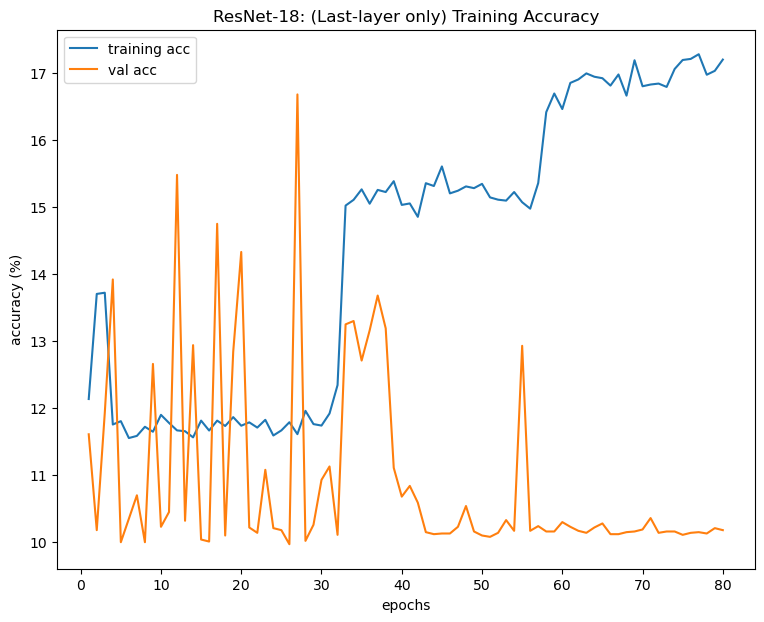

In [34]:
# Visualize ResNet-training-
plt.figure(figsize = (9, 7))
plt.plot(list(training_history_lr_scheduler.keys()), [training_history_lr_scheduler[k]['acc'] for k in training_history_lr_scheduler.keys()], label = 'training acc')
plt.plot(list(training_history_lr_scheduler.keys()), [training_history_lr_scheduler[k]['val_acc'] for k in training_history_lr_scheduler.keys()], label = 'val acc')
plt.title("ResNet-18: (Last-layer only) Training Accuracy")
plt.xlabel("epochs")
plt.ylabel("accuracy (%)")
plt.legend(loc = 'best')
plt.show()

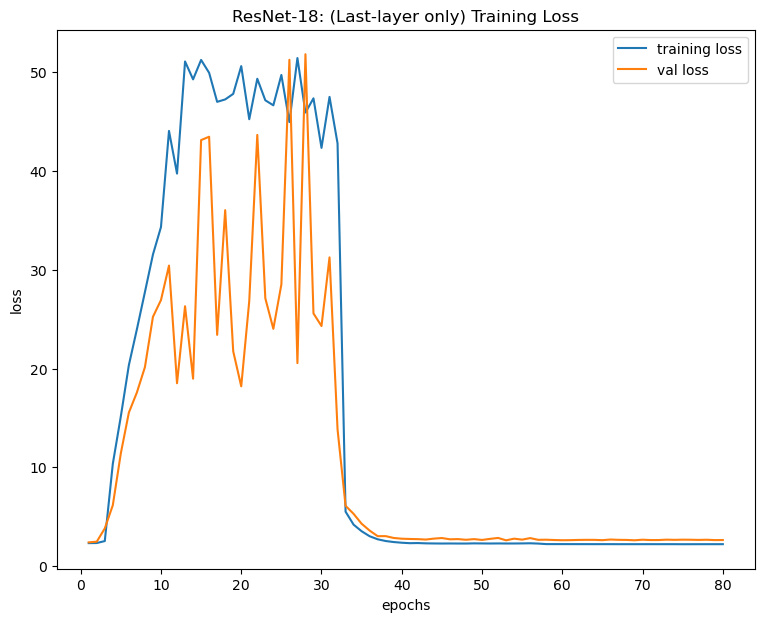

In [35]:
plt.figure(figsize = (9, 7))
plt.plot(list(training_history_lr_scheduler.keys()), [training_history_lr_scheduler[k]['loss'] for k in training_history_lr_scheduler.keys()], label = 'training loss')
plt.plot(list(training_history_lr_scheduler.keys()), [training_history_lr_scheduler[k]['val_loss'] for k in training_history_lr_scheduler.keys()], label = 'val loss')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.legend(loc = 'best')
plt.title("ResNet-18: (Last-layer only) Training Loss")
plt.show()

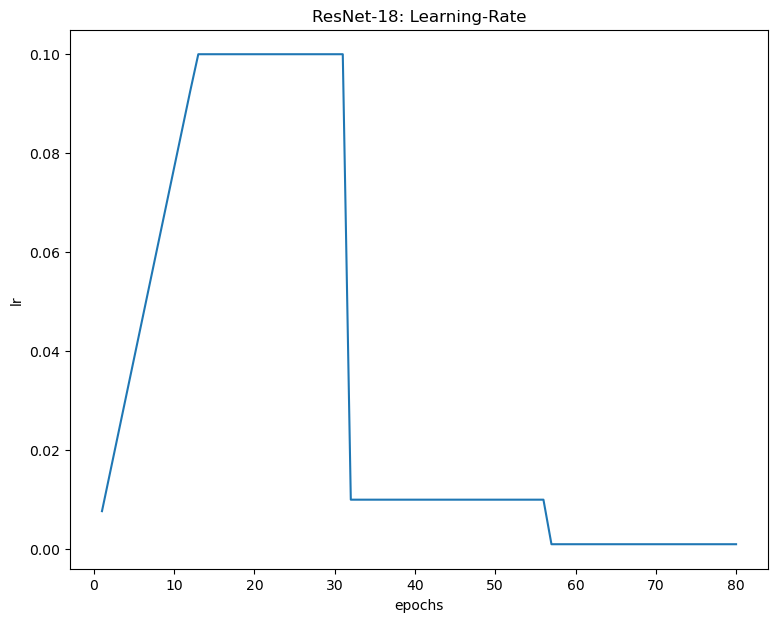

In [36]:
plt.figure(figsize = (9, 7))
plt.plot(list(training_history_lr_scheduler.keys()), [training_history_lr_scheduler[k]['lr'] for k in training_history_lr_scheduler.keys()])
plt.xlabel("epochs")
plt.ylabel("lr")
plt.title("ResNet-18: Learning-Rate")
plt.show()